In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

/Users/baiyusha/Desktop/SBU/AMS595/final group project/.venv1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================
# Load Data
# ============================
panel = pd.read_csv("panel-XGboost.csv")
print("Loaded panel.csv:", panel.shape)

Loaded panel.csv: (15576, 11)


In [3]:
FEATURES = ["relig", "civic", "assn", "pvote", "respn", "nccs", "pop", "year"]
TARGET = "sk"

train = panel[panel["year"] < 2014].copy()
test  = panel[panel["year"] == 2014].copy()

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [4]:
# ============================
# Train XGBoost
# ============================
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse",
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


# ============================
# Predict
# ============================
y_pred_train = xgb_model.predict(X_train)
y_pred_test  = xgb_model.predict(X_test)

# Train metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae  = mean_absolute_error(y_train, y_pred_train)
train_r2   = r2_score(y_train, y_pred_train)

# Test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae  = mean_absolute_error(y_test, y_pred_test)
test_r2   = r2_score(y_test, y_pred_test)

print("\n=== XGBoost Performance (Train) ===")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE : {train_mae:.4f}")
print(f"Train R^2 : {train_r2:.4f}")

print("\n=== XGBoost Performance (Test 2014) ===")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE : {test_mae:.4f}")
print(f"Test R^2 : {test_r2:.4f}")


=== XGBoost Performance (Train) ===
Train RMSE: 0.1642
Train MAE : 0.1142
Train R^2 : 0.9859

=== XGBoost Performance (Test 2014) ===
Test RMSE: 0.4218
Test MAE : 0.3583
Test R^2 : 0.8881


In [5]:
# ============================
# Feature Importance
# ============================
importances = xgb_model.feature_importances_
feat_imp = sorted(zip(FEATURES, importances), key=lambda x: x[1], reverse=True)

print("\n=== Feature Importances ===")
for name, score in feat_imp:
    print(f"{name:10s} : {score:.4f}")



=== Feature Importances ===
pvote      : 0.2749
assn       : 0.2367
respn      : 0.1780
pop        : 0.1262
nccs       : 0.0709
relig      : 0.0438
year       : 0.0364
civic      : 0.0331


/var/folders/l4/47hjx931367cw844tt895w4m0000gn/T/ipykernel_68563/3255178313.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=names, palette=colors)
/var/folders/l4/47hjx931367cw844tt895w4m0000gn/T/ipykernel_68563/3255178313.py:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=scores, y=names, palette=colors)


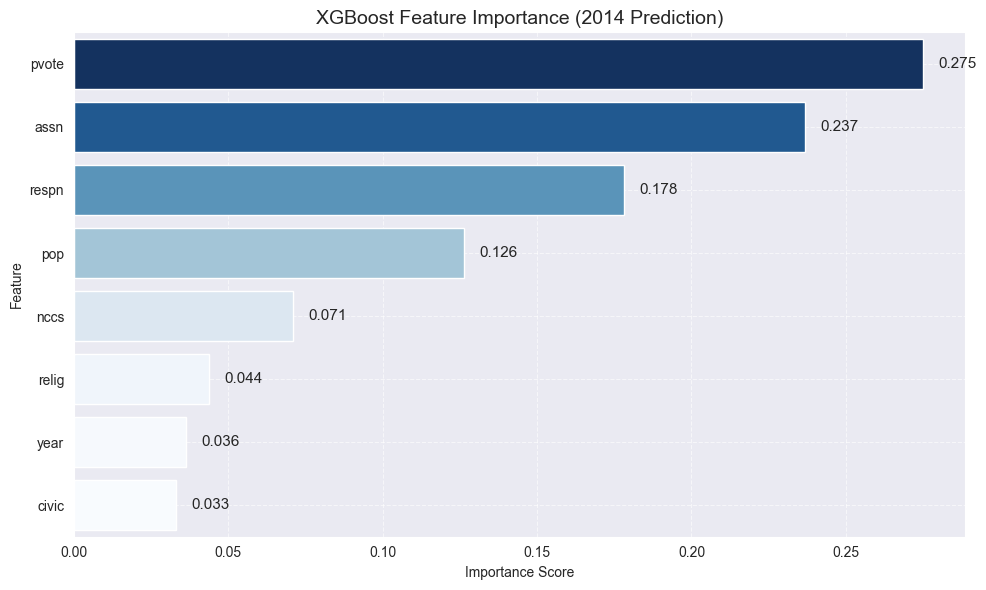

In [7]:
# ---- Sort feature importance descending ----
feat_imp_sorted = sorted(zip(FEATURES, importances), key=lambda x: x[1], reverse=True)

names  = [x[0] for x in feat_imp_sorted]
scores = np.array([x[1] for x in feat_imp_sorted])

plt.figure(figsize=(10, 6))

norm = (scores - scores.min()) / (scores.max() - scores.min())
colors = plt.cm.Blues(norm)
sns.barplot(x=scores, y=names, palette=colors)

for i, score in enumerate(scores):
    plt.text(score + 0.005, i, f"{score:.3f}", va='center', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("XGBoost Feature Importance (2014 Prediction)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plt.tight_layout()
plt.savefig("xgb_feature_importance_gradient.png", dpi=150, bbox_inches='tight')
plt.show()

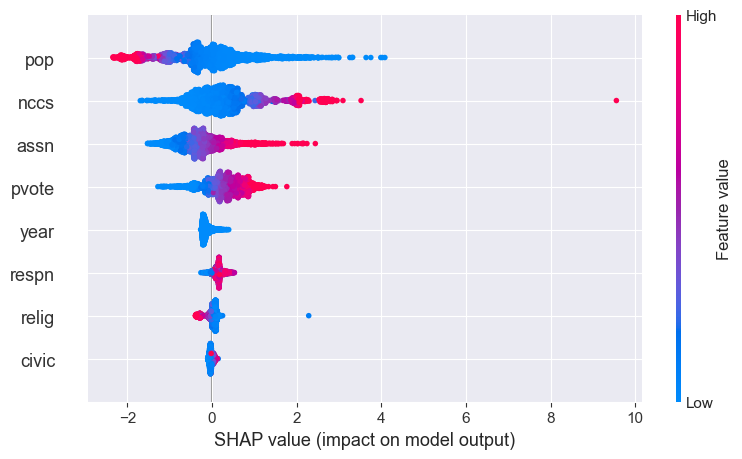

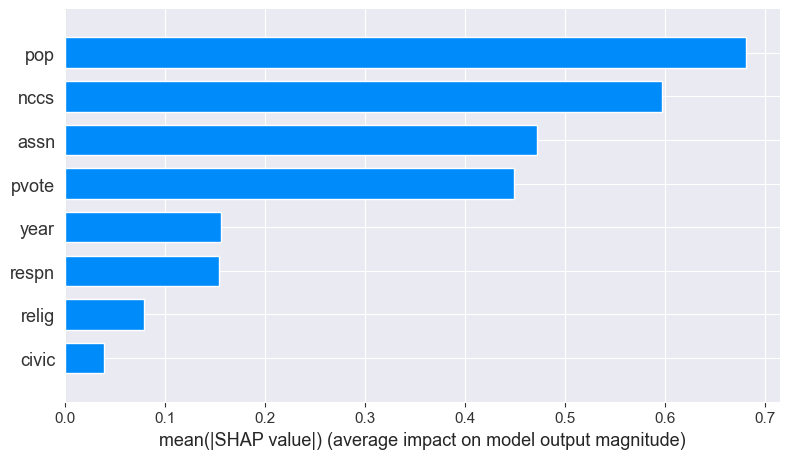

In [8]:
# ============================
# SHAP
# ============================
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")
shap.summary_plot(shap_values, X_test, plot_type="bar")

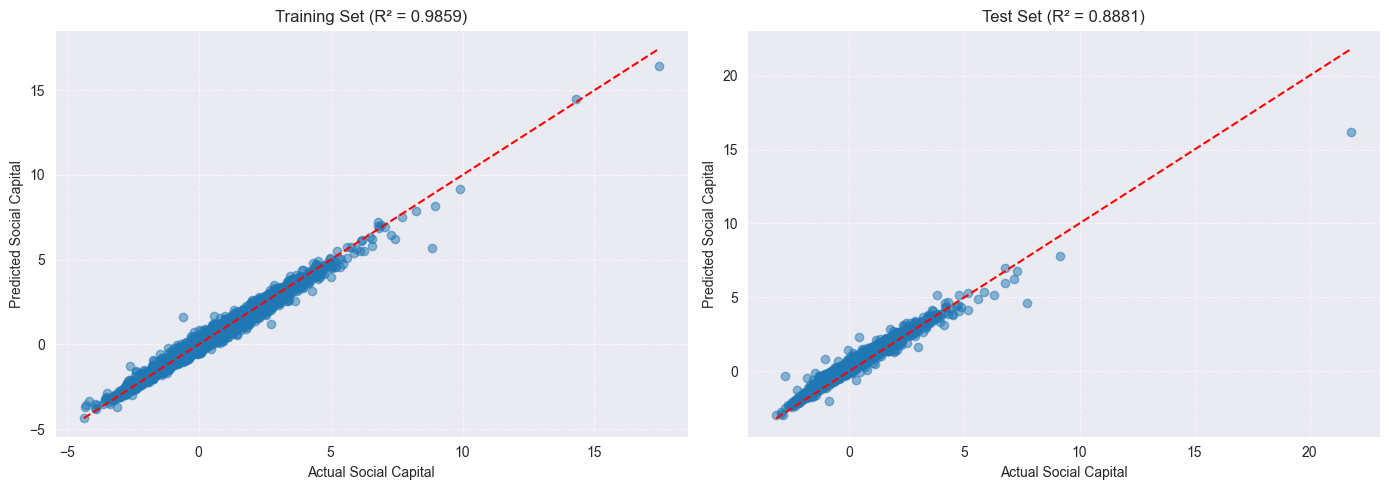

In [9]:
# ============================
# Training vs Test Plots
# ============================
plt.figure(figsize=(14, 5))

# Training
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Actual Social Capital")
plt.ylabel("Predicted Social Capital")
plt.title(f"Training Set (R² = {train_r2:.4f})")

# Test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Actual Social Capital")
plt.ylabel("Predicted Social Capital")
plt.title(f"Test Set (R² = {test_r2:.4f})")

plt.tight_layout()
plt.savefig("xgb_actual_vs_predicted.png", dpi=150, bbox_inches="tight")
plt.show()

In [10]:
# ============================
# Time-Series Cross-Validation
# ============================
years = [1990, 1997, 2005, 2009, 2014]
results = []

for i in range(1, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_df = panel[panel["year"].isin(train_years)]
    test_df  = panel[panel["year"] == test_year]

    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]

    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]

    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    results.append([train_years[-1], test_year, rmse, mae, r2])

print("\n=== Panel Time-Series Cross Validation ===")
for r in results:
    print(f"Train ≤ {r[0]}, Test = {r[1]} | RMSE = {r[2]:.4f}, MAE = {r[3]:.4f}, R² = {r[4]:.4f}")


=== Panel Time-Series Cross Validation ===
Train ≤ 1990, Test = 1997 | RMSE = 2.8283, MAE = 2.6151, R² = -2.8684
Train ≤ 1997, Test = 2005 | RMSE = 0.4552, MAE = 0.3510, R² = 0.8931
Train ≤ 2005, Test = 2009 | RMSE = 0.5236, MAE = 0.4232, R² = 0.8469
Train ≤ 2009, Test = 2014 | RMSE = 0.4218, MAE = 0.3583, R² = 0.8881
